In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import missingno as msno 
import pandas as pd
import numpy as np
import random
import numpy as np
import os
import datetime

# Desafío Spike Septiembre 2020 - Predicción de desviación de precios en el sistema eléctrico chileno
## Alejandro Jaime G.

## 1. Costos marginales

### 1.1 Tratamiento de los datos

#### Lectura datos.

In [2]:
root_folder = 'data/'
df_costo_marginal_programado = pd.read_csv(os.path.join(root_folder,'costo_marginal_programado.csv'))
df_costo_marginal_real = pd.read_csv(os.path.join(root_folder,'costo_marginal_real.csv'))

#### Visualización previa de datos

In [3]:
print('\033[1,37m'+'Costo marginal'+'\x1b[0m')
display(df_costo_marginal_real.head(2))
print('\033[1,37m'+'Costo marginal programado'+'\x1b[0m')
display(df_costo_marginal_programado.head(2))

[1,37mCosto marginal


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV


[1,37mCosto marginal programado


,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2,50.471616


#### Transformacion columna "fecha" a formato datetime de pandas para un mejor manejo de fechas.


In [4]:
df_costo_marginal_programado['fecha'] = df_costo_marginal_programado['fecha'].astype('datetime64[ns]')
df_costo_marginal_programado['fecha'] = pd.to_datetime(df_costo_marginal_programado['fecha'].dt.strftime('%Y-%m-%d'))

df_costo_marginal_real['fecha'] = df_costo_marginal_real['fecha'].astype('datetime64[ns]')
df_costo_marginal_real['fecha'] = pd.to_datetime(df_costo_marginal_real['fecha'].dt.strftime('%Y-%m-%d'))

#### Renombramos las columnas de costos para diferenciarlas sin problemas.

In [5]:
df_costo_marginal_programado.rename(columns={'costo':'costo_dolares_programado'}, inplace=True)
df_costo_marginal_real.rename(columns={'costo_en_dolares':'costo_dolares_real', 'costo_en_pesos':'costo_pesos_real'}, inplace=True)

#### Verificación de consistencia de datos.

Se visualizan datos duplicados.

In [6]:
df_costo_marginal_programado[df_costo_marginal_programado.duplicated()]

,mnemotecnico_barra,nombre_barra,fecha,hora,costo_dolares_programado
987595,-,-,2019-01-01,1,132.435970
987596,-,-,2019-01-01,2,133.357999
987597,-,-,2019-01-01,3,55.675566
987598,-,-,2019-01-01,4,56.834148
987599,-,-,2019-01-01,5,55.536030
...,...,...,...,...,...
1166817,-,-,2019-06-30,20,46.414148
1166818,-,-,2019-06-30,21,48.206563
1166819,-,-,2019-06-30,22,48.136790
1166820,-,-,2019-06-30,23,47.388457


Se realiza un supuesto que viene inferido del conjunto de datos, la triada mnemotecnico_barra, fecha y hora debe ser única, se verifica a continuación.

Además se verifica buscando una barra para una fecha y hora en específico.

In [7]:
display(df_costo_marginal_programado[df_costo_marginal_programado.duplicated(['mnemotecnico_barra','fecha','hora'])])
print('\033[1,37m'+'Verificación de ejemplo de una barra con costo progframado duplicado a nivel barra-fecha-hora'+'\x1b[0m')
display(df_costo_marginal_programado.loc[(df_costo_marginal_programado.mnemotecnico_barra == 'BA83L131SE134L131') & (df_costo_marginal_programado.fecha == '2019-06-06') & (df_costo_marginal_programado.hora == 20)  ])

,mnemotecnico_barra,nombre_barra,fecha,hora,costo_dolares_programado
987115,-,-,2019-01-01,1,134.306196
987116,-,-,2019-01-01,2,134.981636
987117,-,-,2019-01-01,3,56.461802
987118,-,-,2019-01-01,4,57.708776
987119,-,-,2019-01-01,5,56.390681
...,...,...,...,...,...
1192119,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,20,49.387641
1192120,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,21,50.186228
1192121,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,22,50.237093
1192122,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,23,49.969904


[1,37mVerificación de ejemplo de una barra con costo progframado duplicado a nivel barra-fecha-hora


,mnemotecnico_barra,nombre_barra,fecha,hora,costo_dolares_programado
1192095,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,20,52.319394
1192119,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,20,49.387641


Para minizar el impacto que puede causar al comportamiento de los datos lo reemplazaremos por la media y eliminaremos los valores duplicados.

In [8]:
df_costo_marginal_programado['costo_dolares_programado'] = df_costo_marginal_programado.groupby(['mnemotecnico_barra', 'fecha', 'hora'])['costo_dolares_programado'].transform('mean')
df_costo_marginal_programado = df_costo_marginal_programado.drop_duplicates(subset=['mnemotecnico_barra', 'fecha', 'hora'])

Se realiza un merge a nivel barra_mnemotecnico fecha hora del conjunto de datos df_costo_marginal_real y df_costo_marginal_programado y asi obtendremos un nuevo conjunto de datos donde tenemos para una fecha y hora concreta un  **valor real del costo marginal** y su respectivo **valor costo marginal programado**.

In [9]:
df_costo_marginal = pd.merge(df_costo_marginal_real, df_costo_marginal_programado, how='left', left_on=['barra_mnemotecnico','fecha','hora'], right_on=['mnemotecnico_barra','fecha','hora'])
#Por temas de memoria ram y debido a que no utilizaremos los conjuntos de datos originales estos serán eliminados
del df_costo_marginal_programado
del df_costo_marginal_real

In [10]:
print('Vista previa nuevo dataframe')
display(df_costo_marginal.head())

Vista previa nuevo dataframe


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_dolares_real,costo_pesos_real,nombre,mnemotecnico_barra,nombre_barra,costo_dolares_programado
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV,NaN,NaN,NaN
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV,NaN,NaN,NaN
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1,NaN,NaN,NaN
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1,NaN,NaN,NaN
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1,NaN,NaN,NaN


### 1.1 Análisis de los datos

#### Verificación datos NaN

In [11]:
print('Datos NaN por variable para el costo marginal')
df_costo_marginal.isnull().sum()

Datos NaN por variable para el costo marginal


barra_mnemotecnico                     0
barra_referencia_mnemotecnico          0
fecha                                  0
hora                                   0
costo_dolares_real                     0
costo_pesos_real                       0
nombre                                 0
mnemotecnico_barra               3409022
nombre_barra                     3409022
costo_dolares_programado         3409022
dtype: int64

#### Visualizamos a través de un boxplot los valores atípicos o outliers y donde se concentran los valores para cada variable.

<AxesSubplot:>

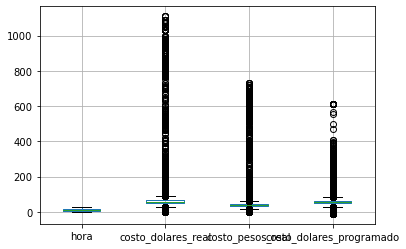

In [12]:
df_costo_marginal.boxplot()

#### Visualizamos a través de un histograma la distribución de los datos, ya que si fuera normal nos podría ser de mucha utilidad.

array([[<AxesSubplot:title={'center':'hora'}>,
        <AxesSubplot:title={'center':'costo_dolares_real'}>],
       [<AxesSubplot:title={'center':'costo_pesos_real'}>,
        <AxesSubplot:title={'center':'costo_dolares_programado'}>]],
      dtype=object)

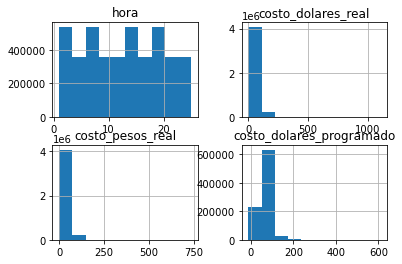

In [13]:
df_costo_marginal.hist()

##### Del análisis previo, se puede identificar que las variables no se distribuyen normalmente y que existe gran cantidad de datos atípicos o outliers que podrían ser representativos de las desviaciones de costos que a futuro se quiere predecir, por lo que no es necesario tratarlos.

In [14]:
print('Se aprecia que para', df_costo_marginal.groupby('barra_mnemotecnico')['costo_dolares_programado'].count().sum(), 'barras se programan costos.')
print('Por otro lado se aprecia que para el',df_costo_marginal.groupby('barra_mnemotecnico')['costo_dolares_programado'].count().sum()/df_costo_marginal.groupby('barra_mnemotecnico').count().sum()[0]*100, '% de las barras se programó un costo marginal.')

Se aprecia que para 900929 barras se programan costos.
Por otro lado se aprecia que para el 20.903462707580665 % de las barras se programó un costo marginal.


## 2.Construcción de variables

In [15]:
df_costo_marginal = df_costo_marginal.assign(desviacion_dolares=lambda x: x.costo_dolares_real - x.costo_dolares_programado )

In [16]:
df_costo_marginal = df_costo_marginal.assign(desviación_pct=lambda x: (x.desviacion_dolares / x.costo_dolares_programado)*100 )

In [17]:
df_costo_marginal['desviacion_cat'] = df_costo_marginal['desviación_pct'].apply(lambda x: 1 if  np.absolute(x) >= 15 else 0 )

In [18]:
df_costo_marginal.sort_values('fecha', inplace=True)

<AxesSubplot:xlabel='fecha'>

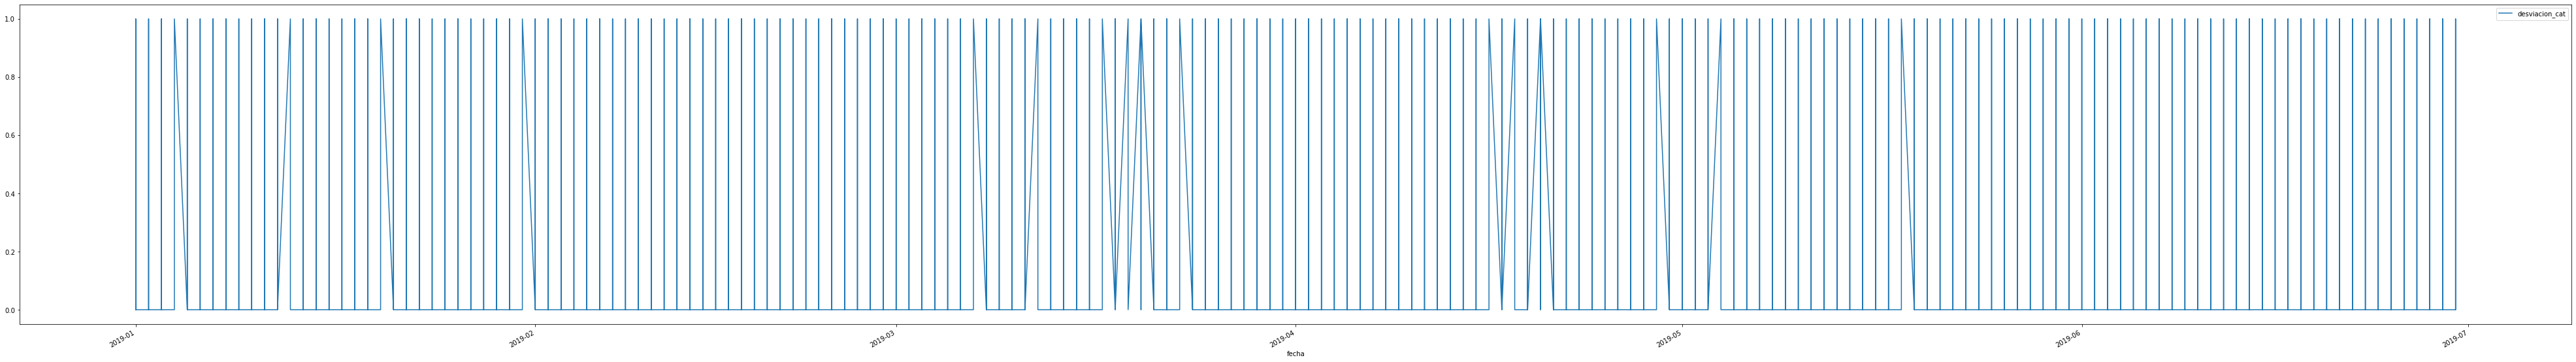

In [19]:
df_costo_marginal.plot(x='fecha', y='desviacion_cat', figsize=(70,10))

Se puede apreciar del gráfico anterior que la variable categórica **desviacion_cat** cambia constantemente a través del tiempo, de hecho se aprecia que el intervalo de un día esta fué variando entre 1 y 0 una gran cantidad de reiteraciones. Por otro lado si la analizamos como señal, se puede visualizar que la frecuencia en ciertos instantes específicos flutúa de manera interesante pero podría ser causado por alguna anomalía en los datos que habría que descartar. Debido a lo anterior si quisieramos implementar algún modelo de IA o estadísticos para capturar el comportamiento este podría presentar inconvenientes para lograrlo.

## 3.Visualización de datos

In [20]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
    fecha_inicial = pd.to_datetime(fecha_inicial,format='%Y-%m-%d')
    fecha_final =  pd.to_datetime(fecha_final,format='%Y-%m-%d')
    data_barra = df_costo_marginal[df_costo_marginal['barra_mnemotecnico']==codigo_barra]
    mask_date = (data_barra['fecha'] >= fecha_inicial) & (data_barra['fecha'] <= fecha_final)
    data_barra = data_barra.loc[mask_date]
    data_barra = data_barra[data_barra.costo_dolares_real != 0]
    data_barra = data_barra.set_index('fecha')
    for i in ['costo_dolares_real','costo_dolares_programado']: 
        data_barra[i].plot(figsize = (21,8), legend = True, title = 'Gráfico en el tiempo de costo_dolares_real v\s costo_dolares_programado (USD) para barra '+codigo_barra)

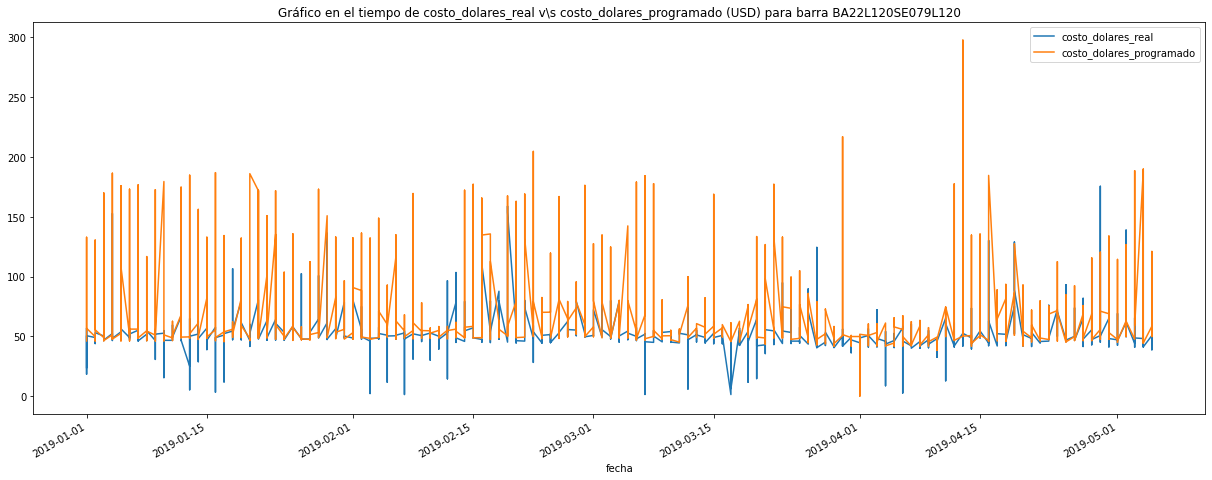

In [21]:
time_plot_costo_barra('BA22L120SE079L120','2019-01-01','2019-05-05')

En la figura anterior se aprecia que el costo programado se ha determinado de tal manera que permita cubrir la mayor cantidad de **costos marginales reales**, pero tiene el inconveniente de no ajustarse de la mejor manera al comportamiento de los costos marginales. Esto tiene relación con el gráfico en el tiempo de la **desviacion_cat** visualizado anteriormente, en donde existen instantes en que la desviación se comporta impredesciblemente por ahora. 

Se asume que el costo programado se realiza por medio de alguna función o método realizada por el propio Sistema Electrico Nacional y su conocimiento del área.

## 4. Base para los modelos

#### Lectura de datos

In [22]:
df_base_prediccion = pd.read_csv(os.path.join(root_folder,'base_para_prediccion.csv'))

#### Análisis de los datos

In [23]:
print('Vista previa dataframe')
df_base_prediccion.head(5)

Vista previa dataframe


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


In [24]:
print('La dimensión de los datos es',df_base_prediccion.shape)
print('\nLos tipos de datos son: \n\n',df_base_prediccion.dtypes)

La dimensión de los datos es (112779, 15)

Los tipos de datos son: 

 nemotecnico_se               object
fecha                        object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
dtype: object


Se puede identificar diferentes tipos de datos, entre los cuales la **fecha** permanece como object, por lo que sería ideal realizar la transformación a datatime porque nos entrega facilmente mejores converciones a minutos,horas,dias,meses y años fácilmente. Por otro lado similar al ejercicio anterior se visualiza la variable **hora** que nos permite tener un índice en los datos.

Entre las variables numéricas se tiene que  existe una gran cantidad de datos NaN, como se puede visualizar en la siguiente imagen

<AxesSubplot:>

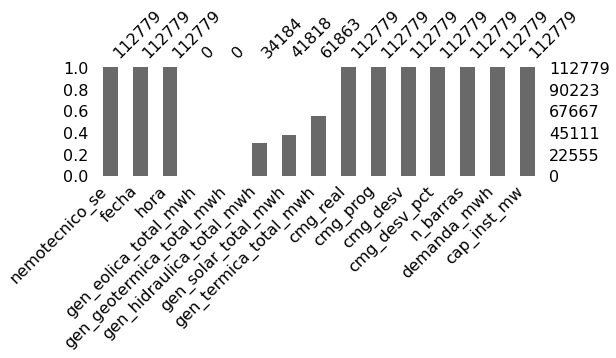

In [25]:
msno.bar(df_base_prediccion, figsize=(8, 2))

#### Realizamos limpieza de datos NaN según corresponda o reemplazamos por la mediana en otros.

Podríamos haber utilizado métodos más complejos para imputar datos como: valores más frecuentes, utlizando algún algoritmo de similitud como KNN, MICE, utilizando Deep Learning, entre otros, pero por la rapidez se utlizó este método. 

In [26]:
df_base_prediccion.drop(['gen_eolica_total_mwh','gen_geotermica_total_mwh'], inplace=True, axis=1)

In [27]:
print('Vista previa nuevo dataframe')
df_base_prediccion.head()

Vista previa nuevo dataframe


,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


#### El rango de fechas comprendidas en el dataset fluctúan entre 2019-01-01 - 2019-06-30

Debido a la sugerencia anterior de transformación de la fecha a datetime, podemos obtener fácilmente diferentes atributos.

In [28]:
df_base_prediccion['fecha'] = df_base_prediccion['fecha'].astype('datetime64[ns]')
df_base_prediccion['fecha'] = pd.to_datetime(df_base_prediccion['fecha'].dt.strftime('%Y-%m-%d'))

In [29]:
df_base_prediccion = df_base_prediccion.sort_values(['fecha', 'hora'], ascending=[True, True])

In [30]:
print('Fecha inicial del conjunto de datos: ', df_base_prediccion['fecha'].min())
print('Fecha final del conjunto de datos: ', df_base_prediccion['fecha'].max())

Fecha inicial del conjunto de datos:  2019-01-01 00:00:00
Fecha final del conjunto de datos:  2019-06-30 00:00:00


In [31]:
df_base_prediccion = df_base_prediccion.assign(año=lambda x: x.fecha.dt.year)
df_base_prediccion = df_base_prediccion.assign(mes=lambda x: x.fecha.dt.month)
df_base_prediccion = df_base_prediccion.assign(dia=lambda x: x.fecha.dt.day)
df_base_prediccion = df_base_prediccion.assign(semana=lambda x: x.fecha.dt.week)
df_base_prediccion = df_base_prediccion.assign(diadelaño=lambda x: x.fecha.dt.dayofyear)
df_base_prediccion = df_base_prediccion.assign(dia_semana=lambda x: x.fecha.dt.dayofweek)

<ipython-input-31-bc55940bae8f>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_base_prediccion = df_base_prediccion.assign(semana=lambda x: x.fecha.dt.week)


Realizamos una transformación para determinar si es dia semana o fin de semana, para el cual:

Dia semana =1
Fin de semana = 0

In [32]:
df_base_prediccion['diasemana_o_findesemana'] = df_base_prediccion['fecha'].apply(lambda x: 1 if x.day <6 else 0 )

Además como iniciativa propia se agregan otras variables adicionales basadas en el tiempo que nos ayuda a capturar tendencias en los datos, en este caso, si es comienzo de quincena  finales de quincena del mes, si es comienzo del mes o fin de mes.

In [33]:
df_base_prediccion['comienzo_cuarto'] = df_base_prediccion['fecha'].apply(lambda x: 1 if x.dayofweek ==15 else 0 )

In [34]:
df_base_prediccion['fin_cuarto'] = df_base_prediccion['fecha'].apply(lambda x: 1 if x.dayofweek ==30 else 0 )

In [35]:
df_base_prediccion['comienzo_mes'] = df_base_prediccion['fecha'].apply(lambda x: 1 if x.dayofweek ==1 else 0 )

In [36]:
df_base_prediccion['fin_mes'] = df_base_prediccion['fecha'].apply(lambda x: 1 if ((x.dayofweek ==30) or (x.dayofweek ==31) ) else 0 )

In [37]:
def time_plot_perfil_gen_solar_subsestacion(subsestacion, variables, lista_fechas):    
    [pd.to_datetime(fecha,format='%Y-%m-%d')  for fecha in lista_fechas]
    data_subsestacion = df_base_prediccion[df_base_prediccion['nemotecnico_se']==subsestacion]
    mask_date = data_subsestacion['fecha'].isin(lista_fechas)
    data_subsestacion = data_subsestacion.loc[mask_date]
    data_subsestacion = data_subsestacion.set_index('fecha')
    data_subsestacion[variables] 
    for i in [variables]: 
        data_subsestacion[i].plot(figsize = (21,8), legend = True, title = 'Gráfico en el tiempo '+str(variables)+' (MWH) para subestación '+(subsestacion))

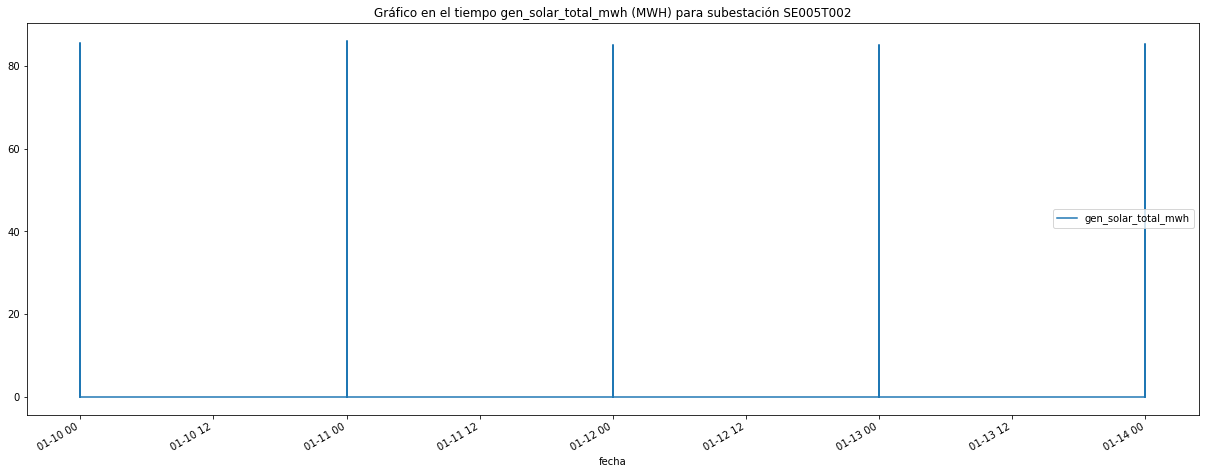

In [38]:
time_plot_perfil_gen_solar_subsestacion('SE005T002','gen_solar_total_mwh', ['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])

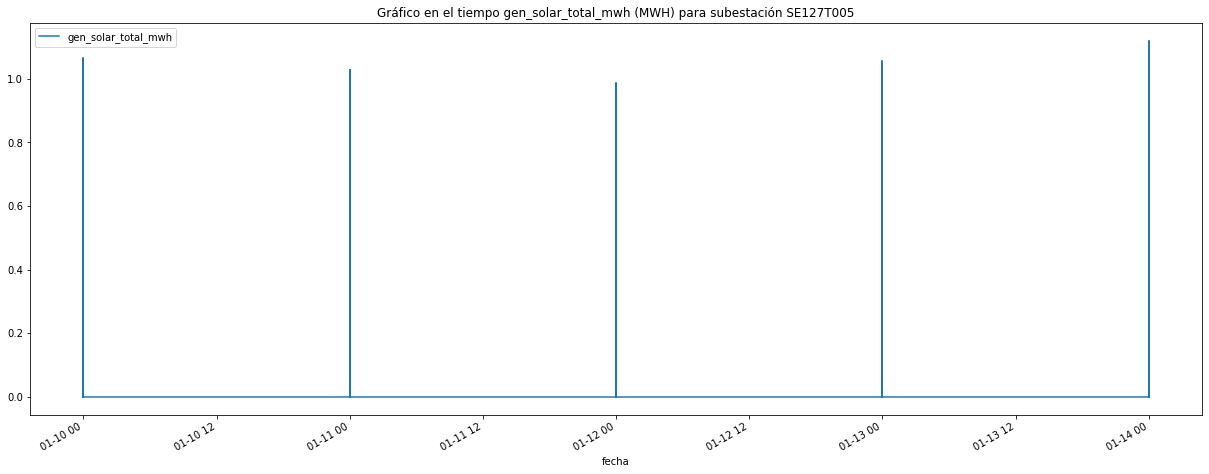

In [39]:
time_plot_perfil_gen_solar_subsestacion('SE127T005','gen_solar_total_mwh', ['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])

Se aprecia que la subestación SE127T005 registra una menor cantidad MWh significativamente, esto puede reflejar que estas dos subestaciones son de diferentes tipos **(transformadores, aisladores, interruptores, etc) y de infraestructura (terreno, edificio, etc)**.

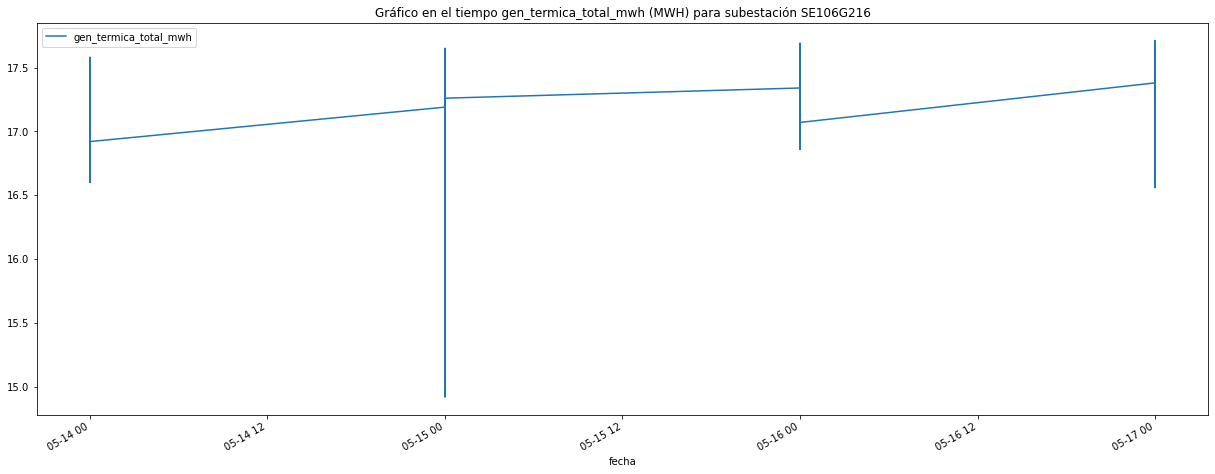

In [40]:
time_plot_perfil_gen_solar_subsestacion('SE106G216','gen_termica_total_mwh', ['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])

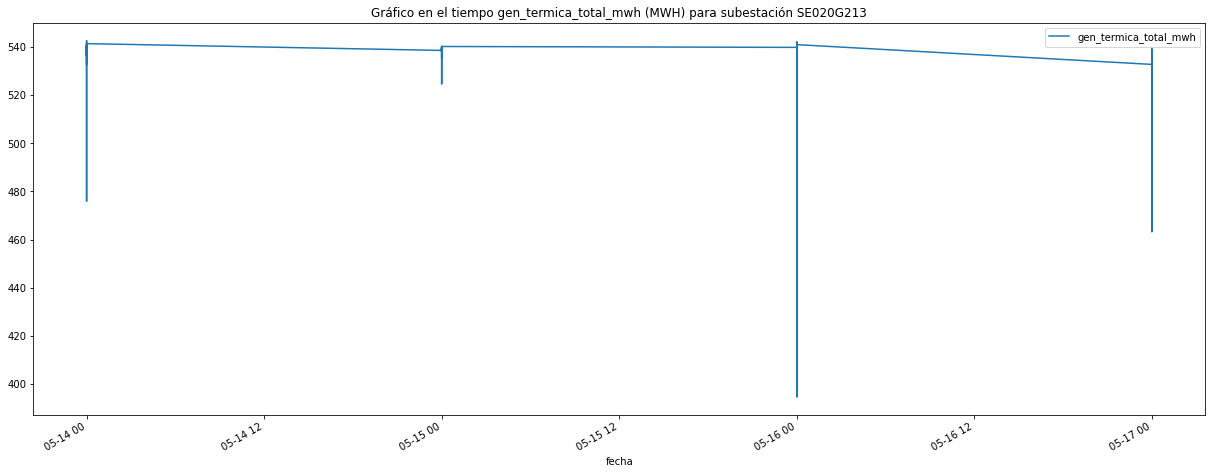

In [41]:
time_plot_perfil_gen_solar_subsestacion('SE020G213','gen_termica_total_mwh', ['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])

Se aprecia que la subestacion SE106G216 registra MWH mucho mas bajos que la subestación SE020G213, esto como en el caso anterior puede reflejar que estas dos subestaciones son de diferentes tipos **(transformadores, aisladores, interruptores, etc) y de infraestructura (terreno, edificio, etc)**. Además si lo contrastamos con la energía solar, se puede inferir que la energia térmica genera mucha mayor cantidad de energia MWH.

## 5. Predicción de desviaciones del costo marginal: modelo 1.

Creamos la variable target

In [42]:
df_base_prediccion['target'] =df_base_prediccion['cmg_desv_pct'].apply(lambda x: 1 if np.absolute(x)>15 else 0)

Creamos una nueva variable sumando las series de generación.

In [43]:
df_base_prediccion = df_base_prediccion.assign(en_total_mwh= lambda x: x.gen_hidraulica_total_mwh + x.gen_solar_total_mwh + x.gen_termica_total_mwh)

In [44]:
df_base_prediccion_modelo_1 = df_base_prediccion.copy()

In [45]:
print('Vista previa nuevo dataframe')
df_base_prediccion_modelo_1.head()

Vista previa nuevo dataframe


,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,...,semana,diadelaño,dia_semana,diasemana_o_findesemana,comienzo_cuarto,fin_cuarto,comienzo_mes,fin_mes,target,en_total_mwh
120,SE001T002,2019-01-01,1,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,...,1,1,1,1,0,0,1,0,1,NaN
4465,SE003T011,2019-01-01,1,0.0,NaN,NaN,49.51,49.311532,0.20,0.41,...,1,1,1,1,0,0,1,0,0,NaN
8810,SE004L079,2019-01-01,1,NaN,NaN,0.0,51.35,50.810035,0.54,1.06,...,1,1,1,1,0,0,1,0,0,NaN
13155,SE004T002,2019-01-01,1,NaN,NaN,23.0,50.77,50.824160,-0.05,-0.10,...,1,1,1,1,0,0,1,0,0,NaN
17500,SE005R002,2019-01-01,1,NaN,0.0,NaN,51.23,50.709314,0.52,1.03,...,1,1,1,1,0,0,1,0,0,NaN


In [46]:
df_base_prediccion_modelo_1.columns

Index(['nemotecnico_se', 'fecha', 'hora', 'gen_hidraulica_total_mwh',
       'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog',
       'cmg_desv', 'cmg_desv_pct', 'n_barras', 'demanda_mwh', 'cap_inst_mw',
       'año', 'mes', 'dia', 'semana', 'diadelaño', 'dia_semana',
       'diasemana_o_findesemana', 'comienzo_cuarto', 'fin_cuarto',
       'comienzo_mes', 'fin_mes', 'target', 'en_total_mwh'],
      dtype='object')

Reemplazamos los valores infinitos a NaN para posteriormente filtrarlos o rellenenar con la mediana.

In [47]:
df_base_prediccion_modelo_1 = df_base_prediccion_modelo_1.replace([np.inf, -np.inf], np.nan)

#### Creamos variables estadísticas acumuladas para cada variable de energía (MWH).

Para ello creamos una función que permitirá agregar variables acumuladas de forma más sencilla"y dinámica.

In [48]:
def generate_var_acomulated(df, variables):
     for var in variables:    
        df[var+'_std_acumulated'] = df[var].expanding(2).std()
        df[var+'_mean_acumulated'] = df[var].expanding(2).mean()
        df[var+'_var_acumulated'] = df[var].expanding(2).var() 

In [49]:
variables = ['gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_desv','cmg_real']
generate_var_acomulated(df_base_prediccion_modelo_1, variables)

#### Creamos variables con lag que permitan ayudar a capturar el comportamiento de los datos para cada variable de energía (MWH).

Estas variables son sumamente importantes porque así se logra generar patrones del pasado que se evaluarán en el presente.

Se crea una función para realizar lags dinámicamente y de manera mas sencilla.

In [50]:
def generate_lags(df, variables, size_windows):
    for windows in size_windows:   
        for var in variables:
            df[var+'_std_lag_'+str(windows)] = df[var].rolling(windows).std()
            df[var+'_mean_lag_'+str(windows)] = df[var].rolling(windows).mean()
            df[var+'_var_lag_'+str(windows)] = df[var].rolling(windows).var()

Se generan variables con difentes lags para poder capturar comportamientos implícitos en los datos.

In [51]:
lags =[12,23,720,1440]
generate_lags(df_base_prediccion_modelo_1, variables, lags)

In [52]:
df_base_prediccion_modelo_1['target'] = df_base_prediccion_modelo_1['target'].shift(-1)

Se prepara el target y se eliminar los datos NaN.

In [53]:
df_base_prediccion_modelo_1 = df_base_prediccion_modelo_1[df_base_prediccion_modelo_1['target'].notna()]
df_base_prediccion_modelo_1.fillna(df_base_prediccion_modelo_1.median(), inplace=True)
df_base_prediccion_modelo_1.reset_index(inplace=True)
df_base_prediccion_modelo_1.fillna(0, inplace=True)

del df_base_prediccion_modelo_1['index']

<ipython-input-53-766d8675784d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_base_prediccion_modelo_1.fillna(df_base_prediccion_modelo_1.median(), inplace=True)
/home/aletenista/miniconda3/envs/ds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Recordamos la fecha minima y la máxima para nuestro conjunto de datos y preparamos los conjunto de datos de train, test y validation según una fecha y hora límite.

In [54]:
print('Fecha inicial del conjunto de datos: ', df_base_prediccion['fecha'].min(),  df_base_prediccion['hora'].min())
print('Fecha final del conjunto de datos: ', df_base_prediccion['fecha'].max(), df_base_prediccion['hora'].max())

Fecha inicial del conjunto de datos:  2019-01-01 00:00:00 1
Fecha final del conjunto de datos:  2019-06-30 00:00:00 25


In [55]:
mask = ((df_base_prediccion_modelo_1['fecha'] < '2019-06-30') & (df_base_prediccion_modelo_1['hora'] < 23))

#### Dividimos nuestros datos En X_train, y_train, X_test, y_test
No se utiliza validación debido al tiempo y a que es necesario si el modelo presenta overfitting, el cual veremos más adelante no es el caso.

In [56]:
y = df_base_prediccion_modelo_1.pop('target')
X = df_base_prediccion_modelo_1.copy()
var_removes = ['nemotecnico_se','fecha']
X.drop(var_removes, axis = 1, inplace = True)

In [57]:
X_train = X.loc[mask]
X_test = X.loc[~mask]
y_train = y.loc[mask]
y_test = y.loc[~mask]

In [58]:
norm = StandardScaler().fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

In [59]:
print('Tamaño Datos Train: ',X_train.shape)
print('Tamaño Datos Test: ',X_test.shape)

Tamaño Datos Train:  (102828, 98)
Tamaño Datos Test:  (9950, 98)


In [60]:
print('Distribución de categorías en Train: ',np.unique(y_train, return_counts=True)[1])

Distribución de categorías en Train:  [77454 25374]


Se escogió Random Forest, debido a que por su naturaleza de bosque aleatorio permite conllevar diferentes problemas de los datos, como la multicolinealidad de las variables y porque posee una menor cantidad de hiperparámetros que optimizar. Por otro lado debido a la gran cantidad de variables que disponemos es probable que suframos de overfitting y para evitarlo es importante reducir la cantidad máxima de variables a utilizar en el Train del modelo **max_features**; en este caso configurado en la raiz cuadrada.
Además se seguirá utilizando el mismo método ensamblado para la construcción de los otros modelos por las razones anteriores y tiempo.

In [61]:
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', criterion='entropy', random_state = 2298)
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       random_state=2298)

Creamos una función para mostrar el rendimiento del modelo de manera mas sencilla y dinámica.

In [62]:
def get_metrics_model(X_test, y_test, model, threshold):
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred_threshold = (y_pred > threshold)*1
    print(classification_report(y_test, y_pred_threshold))
    fpr, tpr, _ = roc_curve(y_test,  y_pred_threshold)
    auc = roc_auc_score(y_test, y_pred_threshold)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.suptitle('Cruva Roc para modelo', fontsize=15)
    plt.xlabel('TRP', fontsize=10)
    plt.ylabel('FPR', fontsize=10)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      6834
         1.0       0.88      0.87      0.88      3116

    accuracy                           0.92      9950
   macro avg       0.91      0.91      0.91      9950
weighted avg       0.92      0.92      0.92      9950



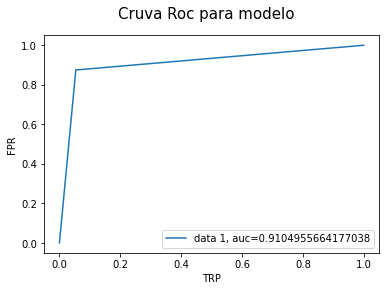

In [63]:
get_metrics_model(X_test, y_test, rf, 0.45)

El modelo logra capturar la desviación por sobre |15%|, pero para capturar la mayor cantidad de verdaderos positivos se ha modificado el threshold de 0.5 (default) a 0.39, logrando incrementar el auc de 0.89 a 0.91, esta métrica se escogió para evaluar el modelo ya que nos muestra el grado de separación que logra realizar el modelo para clasificar correctamente si existe o no una desviación sobre |15%| del cmg_desv_pct. 

La curva nos logra representar fácilmente la capacidad de generalización del modelo entrenado, mientras mas alto en el eje de las ordenas y mas cercana a cero en el eje de las abscisas o mientras mayor sea el área bajo la curva, mejor será el rendimiento).  
Por otro lado podrían obtenerse mejores resultados logrando una optimización de los hyperparámetros del modelo a través Fine Tuning manual o por alguna librería como hyperopt.

#### A continuación podemos observar las características más importantes que utiliza el modelo para clasificar.

Debido a la cantidad de datos shap tiende a demorarse en entregar el gráfico de importancia de variables, por lo que se deja comentado y utilizamos el método disponible del propio método ensamblado Random Forest.

In [64]:
#Por la gran cantidad de datos shap se demora en entregar el gráfico, por lo que se deja comentado
# import shap 
# shap_values = shap.TreeExplainer(rf).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

<AxesSubplot:title={'center':'Feature importance'}>

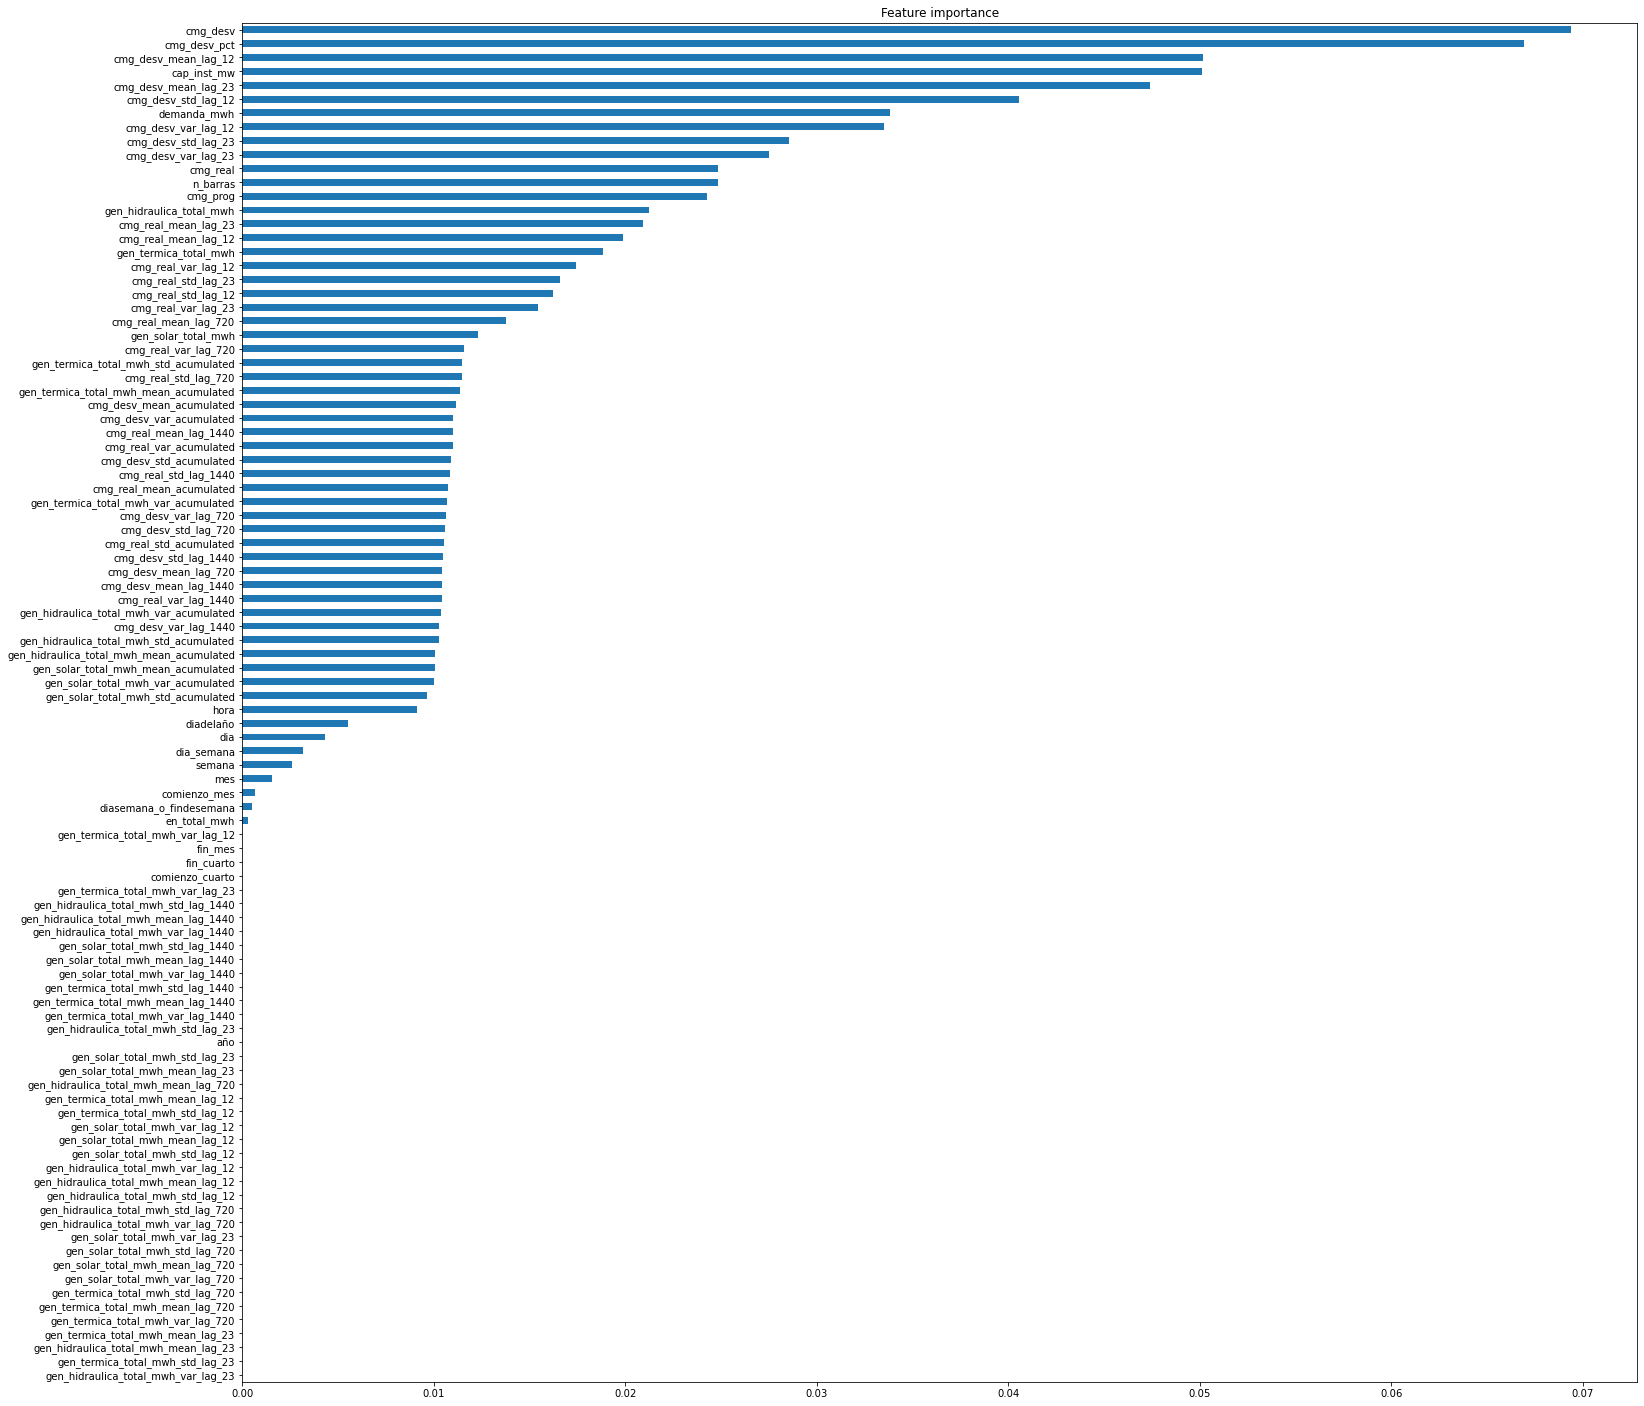

In [65]:
pd.Series(rf.feature_importances_,index=X.columns).sort_values().plot(kind='barh', title='Feature importance', figsize=(25,25))

Se puede apreciar del gráfico anterior que las variables más importantes son las que generarn un retraso en los datos (lags), esto sucede ya que Random Forest no trae información del pasado al presente a diferencia como alguna Red Neuronal Recurrente que ayudan a generar patrones del pasado que se evaluarán en el presente.

## 6. Predicción de desviaciones del costo marginal: modelo 2

En el caso de que suceda al situación de que estando en producción se comiencen a recibir datos cada 12 horas, una opción seria modificar el target de tal manera que se prediga la probabilidad de evento de una desviación cada 12 horas, esto debido que al recibir datos cada 12 horas no se tendría los datos necesarios para calibrar el modelo y lograr una predicción cada 1 hora.

In [66]:
df_base_prediccion_modelo_2 = df_base_prediccion.copy()

In [67]:
df_base_prediccion_modelo_2.columns

Index(['nemotecnico_se', 'fecha', 'hora', 'gen_hidraulica_total_mwh',
       'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog',
       'cmg_desv', 'cmg_desv_pct', 'n_barras', 'demanda_mwh', 'cap_inst_mw',
       'año', 'mes', 'dia', 'semana', 'diadelaño', 'dia_semana',
       'diasemana_o_findesemana', 'comienzo_cuarto', 'fin_cuarto',
       'comienzo_mes', 'fin_mes', 'target', 'en_total_mwh'],
      dtype='object')

Reemplazamos los valores infinitos a NaN para posteriormente filtrarlos o rellenenar con la media.

In [68]:
df_base_prediccion_modelo_2 = df_base_prediccion_modelo_2.replace([np.inf, -np.inf], np.nan)

Generamos variables acumuladas deacuerdo al nivel de importancia visto en el modelo 1.

In [69]:
variables = ['gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh','cmg_real','cmg_desv','cmg_desv_pct']
generate_var_acomulated(df_base_prediccion_modelo_2, variables)

En este caso se escogen lags deacuerdo al desfase de 12 horas, intentando capturar la tendencia de los datos.

In [70]:
lags =[2,12, 24]
generate_lags(df_base_prediccion_modelo_2, variables, lags)

Se realiza un shift -12 debido al desfase de entrega de datos en producción y no dispondremos de datos cada una hora.

In [71]:
df_base_prediccion_modelo_2['target'] = df_base_prediccion_modelo_2['target'].shift(-12)

Eliminamos NaN y rellenamos con la mediana, para luego las variables con lags rellenarlas con 0 para completar el desfase que generar en los datos.

In [72]:
df_base_prediccion_modelo_2 = df_base_prediccion_modelo_2[df_base_prediccion_modelo_2['target'].notna()]
df_base_prediccion_modelo_2.fillna(df_base_prediccion_modelo_2.median(), inplace=True)
df_base_prediccion_modelo_2.fillna(0, inplace=True)

<ipython-input-72-844ceef168d6>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_base_prediccion_modelo_2.fillna(df_base_prediccion_modelo_2.median(), inplace=True)
/home/aletenista/miniconda3/envs/ds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [73]:
df_base_prediccion_modelo_2.reset_index(inplace=True)
del df_base_prediccion_modelo_2['index']

In [74]:
print('Fecha inicial del conjunto de datos: ', df_base_prediccion_modelo_2['fecha'].min(),  df_base_prediccion_modelo_2['hora'].min())
print('Fecha final del conjunto de datos: ', df_base_prediccion_modelo_2['fecha'].max(), df_base_prediccion_modelo_2['hora'].max())

Fecha inicial del conjunto de datos:  2019-01-01 00:00:00 1
Fecha final del conjunto de datos:  2019-06-30 00:00:00 25


#### Dividimos nuestros datos En X_train, y_train, X_test, y_test
No se utiliza validación debido al tiempo y a que es necesario si el modelo presenta overfitting.

In [75]:
mask = ((df_base_prediccion_modelo_2['fecha'] < '2019-06-30') & (df_base_prediccion_modelo_2['hora'] < 14))

In [76]:
y = df_base_prediccion_modelo_2.pop('target')
X = df_base_prediccion_modelo_2.copy()

In [77]:
X_train = X.loc[mask]
X_test = X.loc[~mask]
y_train = y.loc[mask]
y_test = y.loc[~mask]

var_removes = ['nemotecnico_se','fecha']

X_train.drop(var_removes, axis = 1, inplace = True)
X_test.drop(var_removes, axis = 1, inplace = True)

/home/aletenista/miniconda3/envs/ds/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Se estandarizan las variables ya que las tendencias pueden oscilar vertiginosamente y causar un deterioro en la generalización del modelo.

In [78]:
norm = StandardScaler().fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

In [79]:
print('Tamaño Datos Train: ',X_train.shape)
print('Tamaño Datos Test: ',X_test.shape)

Tamaño Datos Train:  (60762, 95)
Tamaño Datos Test:  (52005, 95)


In [80]:
print('Distribución de categorías en Train: ',np.unique(y_train, return_counts=True)[1])

Distribución de categorías en Train:  [47595 13167]


In [81]:
rf = RandomForestClassifier(n_estimators=25, max_features='sqrt', criterion='entropy', random_state = 2298)
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=25, random_state=2298)

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     36684
         1.0       0.82      0.60      0.69     15321

    accuracy                           0.84     52005
   macro avg       0.83      0.77      0.79     52005
weighted avg       0.84      0.84      0.83     52005



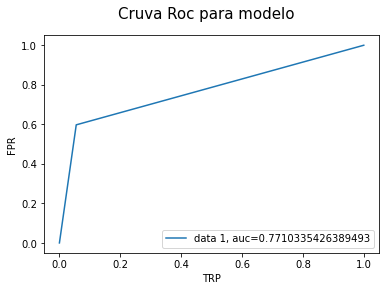

In [82]:
get_metrics_model(X_test, y_test, rf, 0.50)

Si realizamos una comparación del modelo 1 v/s modelo 2, se aprecia:
1. Modelo 1: al tener datos más recientes y una mayor cantidad de **puntos** de datos en donde se necesita una gran cantidad de puntos, demuestra tener un mejor rendimiento.
2. Modelo 2: logra una buena generalización pero se ve limitado debido a la modificación en producción del tiempo de actualización de datos de 12 hrs, una forma de mejorar el resultado sería lograr capturar otras variables no consideradas.

<AxesSubplot:title={'center':'Feature importance'}>

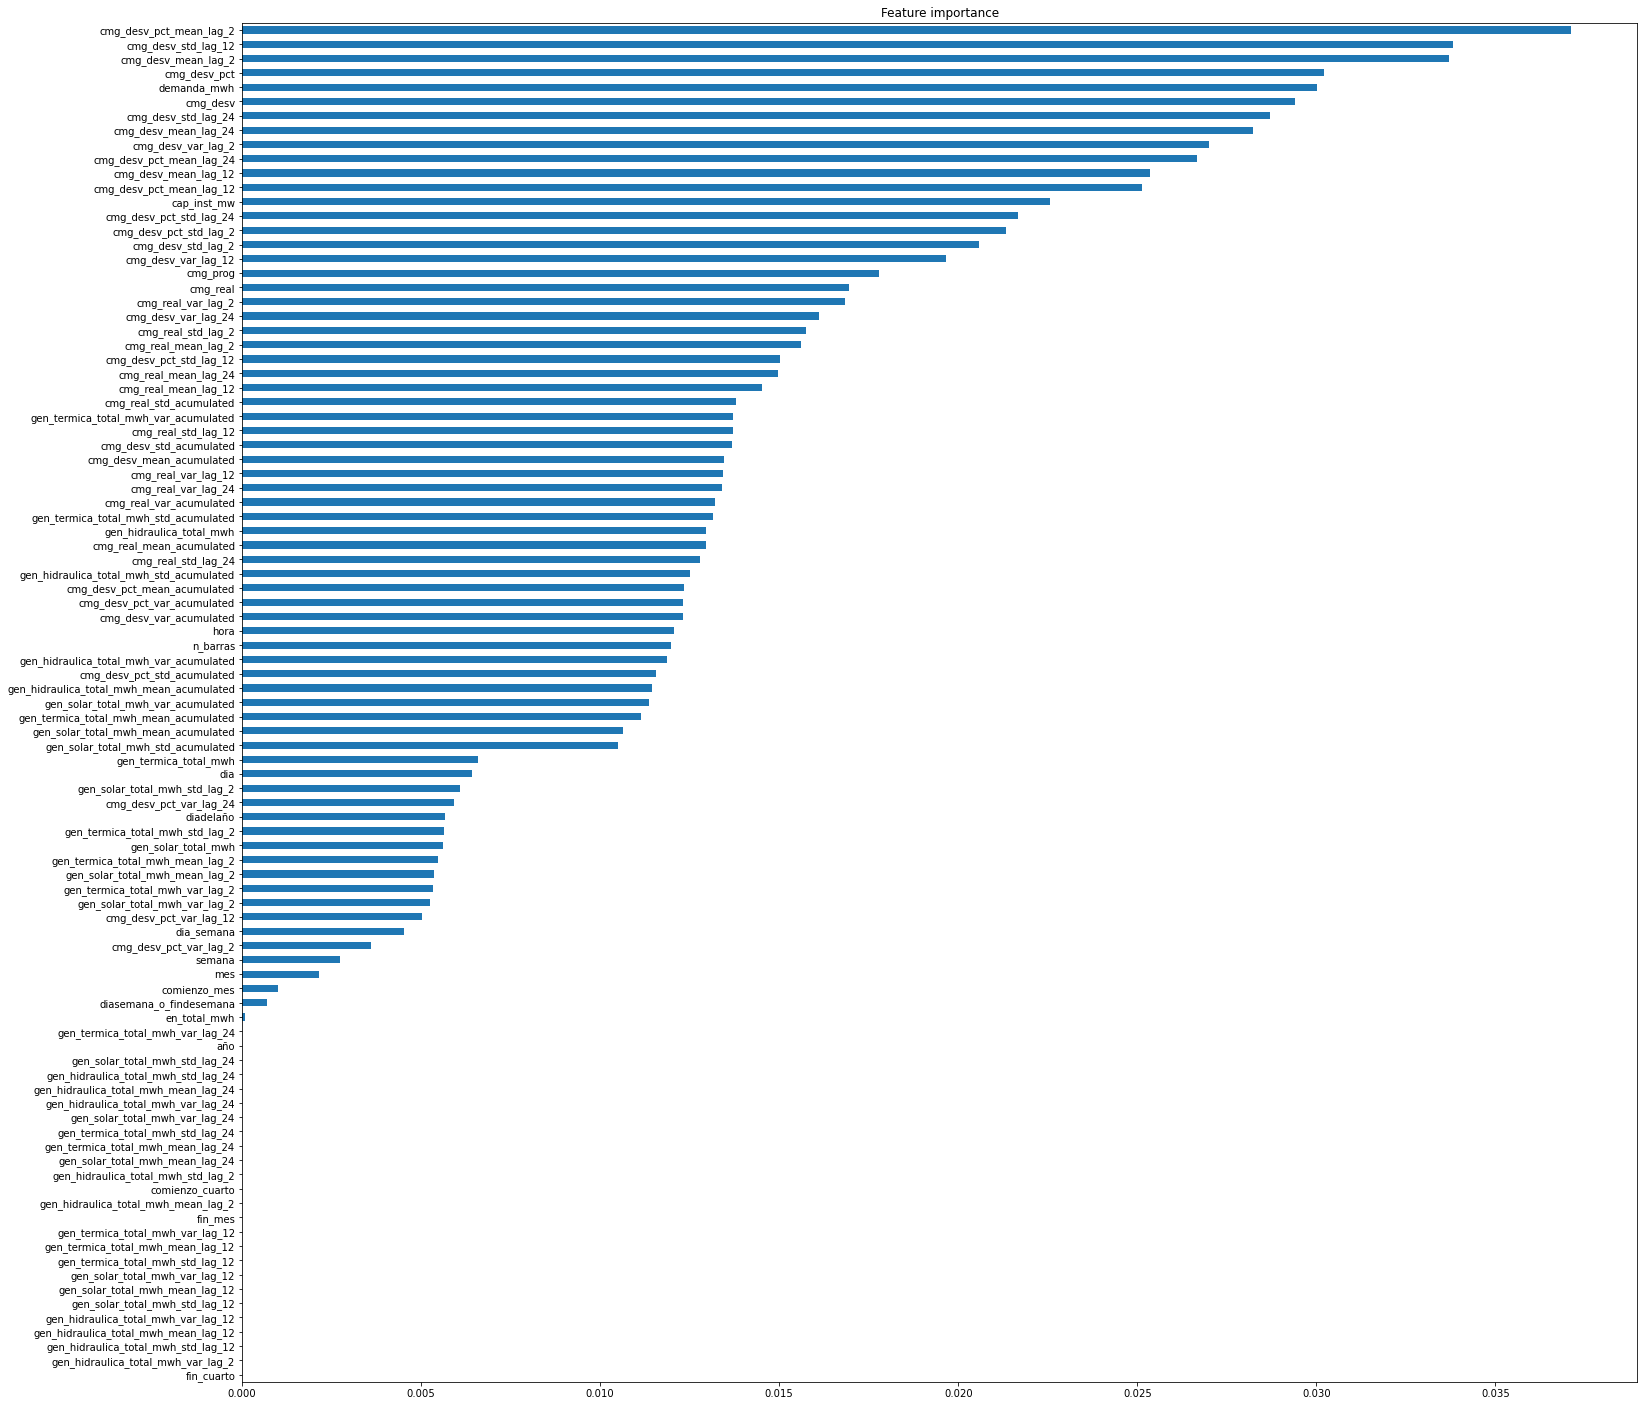

In [83]:
pd.Series(rf.feature_importances_,index=X.drop(['nemotecnico_se','fecha'], axis=1).columns).sort_values().plot(kind='barh', title='Feature importance', figsize=(25,25))

Se puede apreciar del gráfico anterior que las variables más importantes son las que generan un retraso en los datos (lags), esto sucede ya que Random Forest no trae información del pasado al presente a diferencia como alguna Red Neuronal Recurrente que ayudan a generar patrones del pasado que se evaluarán en el presente.
En este caso particular se aprecia que las variables de lag con valor de 30 unidades el modelo le asigna mayor importancia.

## 7. Merge con datos de clima: modelo 3

#### Lectura de datos

In [84]:
df_base_prediccion_modelo_3 = df_base_prediccion.copy()

In [85]:
df_datos_clima = pd.read_csv(os.path.join(root_folder,'datos_clima.csv'))

In [86]:
df_datos_clima['fecha'] = df_datos_clima['fecha'].astype('datetime64[ns]')
df_datos_clima['fecha'] = pd.to_datetime(df_datos_clima['fecha'].dt.strftime('%Y-%m-%d'))

In [87]:
df_base_prediccion_modelo_3 = pd.merge(df_base_prediccion_modelo_3, df_datos_clima, how='left', left_on=['fecha','nemotecnico_se'], right_on=['fecha','subestacion'])

In [88]:
df_base_prediccion_modelo_3 = df_base_prediccion_modelo_3.replace([np.nan, np.inf, -np.inf], np.nan)

<AxesSubplot:>

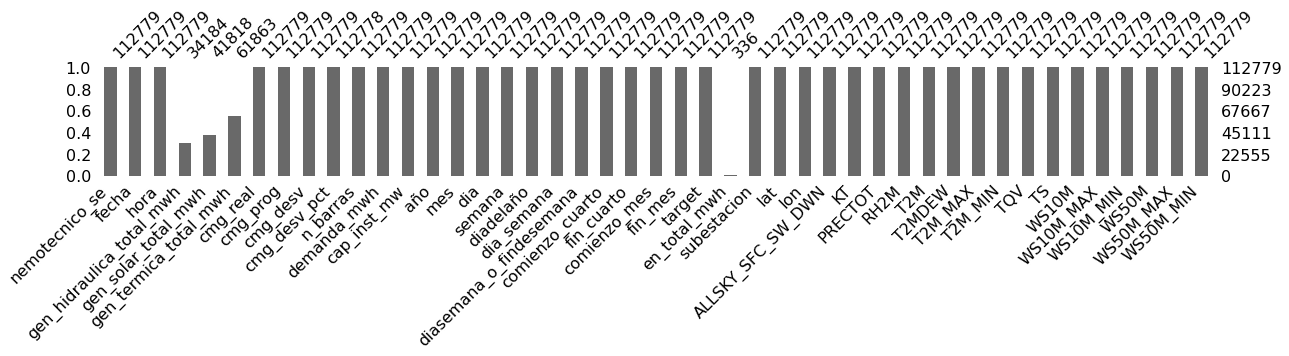

In [89]:
msno.bar(df_base_prediccion_modelo_3, figsize=(20, 2))

In [90]:
df_base_prediccion_modelo_3.columns

Index(['nemotecnico_se', 'fecha', 'hora', 'gen_hidraulica_total_mwh',
       'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog',
       'cmg_desv', 'cmg_desv_pct', 'n_barras', 'demanda_mwh', 'cap_inst_mw',
       'año', 'mes', 'dia', 'semana', 'diadelaño', 'dia_semana',
       'diasemana_o_findesemana', 'comienzo_cuarto', 'fin_cuarto',
       'comienzo_mes', 'fin_mes', 'target', 'en_total_mwh', 'subestacion',
       'lat', 'lon', 'ALLSKY_SFC_SW_DWN', 'KT', 'PRECTOT', 'RH2M', 'T2M',
       'T2MDEW', 'T2M_MAX', 'T2M_MIN', 'TQV', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS50M', 'WS50M_MAX', 'WS50M_MIN'],
      dtype='object')

In [91]:
variables =['gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh','cmg_real','cmg_desv','cmg_desv_pct','WS10M_MIN','WS10M_MAX','WS50M_MIN','WS50M_MAX','WS10M_MIN']
lags =[2,7,12]
generate_lags(df_base_prediccion_modelo_3, variables, lags)

In [92]:
generate_var_acomulated(df_base_prediccion_modelo_3, variables)

In [93]:
df_base_prediccion_modelo_3.columns

Index(['nemotecnico_se', 'fecha', 'hora', 'gen_hidraulica_total_mwh',
       'gen_solar_total_mwh', 'gen_termica_total_mwh', 'cmg_real', 'cmg_prog',
       'cmg_desv', 'cmg_desv_pct',
       ...
       'WS10M_MIN_var_acumulated', 'WS10M_MAX_std_acumulated',
       'WS10M_MAX_mean_acumulated', 'WS10M_MAX_var_acumulated',
       'WS50M_MIN_std_acumulated', 'WS50M_MIN_mean_acumulated',
       'WS50M_MIN_var_acumulated', 'WS50M_MAX_std_acumulated',
       'WS50M_MAX_mean_acumulated', 'WS50M_MAX_var_acumulated'],
      dtype='object', length=165)

In [94]:
df_base_prediccion_modelo_3['target'] = df_base_prediccion_modelo_3['target'].shift(-12)

Reemplazamos los valores infinitos a NaN para posteriormente filtrarlos o rellenenar con la media.

In [95]:
df_base_prediccion_modelo_3 = df_base_prediccion_modelo_3[df_base_prediccion_modelo_3['target'].notna()]
df_base_prediccion_modelo_3.fillna(df_base_prediccion_modelo_3.median(), inplace=True)
df_base_prediccion_modelo_3.fillna(0, inplace=True)

<ipython-input-95-6e66670e0326>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_base_prediccion_modelo_3.fillna(df_base_prediccion_modelo_3.median(), inplace=True)
/home/aletenista/miniconda3/envs/ds/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [96]:
df_base_prediccion_modelo_3.reset_index(inplace=True)
del df_base_prediccion_modelo_3['index']

In [97]:
print('Fecha inicial del conjunto de datos: ', df_base_prediccion_modelo_3['fecha'].min(),  df_base_prediccion_modelo_3['hora'].min())
print('Fecha final del conjunto de datos: ', df_base_prediccion_modelo_3['fecha'].max(), df_base_prediccion_modelo_3['hora'].max())

Fecha inicial del conjunto de datos:  2019-01-01 00:00:00 1
Fecha final del conjunto de datos:  2019-06-30 00:00:00 25


Para manejar el Data Leakage, crearemos un conjunto de datos de validación. 

Teniendo un conjunto de Train, Validation y Test 

In [98]:
mask = ((df_base_prediccion_modelo_3['fecha'] < '2019-06-30') & (df_base_prediccion_modelo_3['hora'] < 14))

#### Dividimos nuestros datos En X_train, y_train, X_test, y_test
No se utiliza validación debido al tiempo y a que es necesario si el modelo presenta overfitting, el cual veremos que más adelante no es el caso.

In [99]:
y = df_base_prediccion_modelo_3.pop('target')
X = df_base_prediccion_modelo_3.copy()
var_removes = ['nemotecnico_se','fecha','subestacion']
X.drop(var_removes, axis = 1, inplace = True)

In [100]:
X_train = X.loc[mask]
X_test = X.loc[~mask]

y_train = y.loc[mask]
y_test = y.loc[~mask]

Se estandarizan las variables ya que las tendencias pueden oscilar vertiginosamente y causar un deterioro en la generalización del modelo.

In [101]:
norm = StandardScaler().fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

In [102]:
print('Tamaño Datos Train: ',X_train.shape)
print('Tamaño Datos Test: ',X_test.shape)

Tamaño Datos Train:  (60762, 161)
Tamaño Datos Test:  (52005, 161)


In [103]:
print('Distribución de categorías en Train: ',np.unique(y_train, return_counts=True)[1])

Distribución de categorías en Train:  [47595 13167]


In [104]:
rf = RandomForestClassifier(n_estimators=25, max_features='sqrt', criterion='gini', random_state = 2298)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=25, random_state=2298)

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     36684
         1.0       0.76      0.72      0.74     15321

    accuracy                           0.85     52005
   macro avg       0.82      0.81      0.82     52005
weighted avg       0.85      0.85      0.85     52005



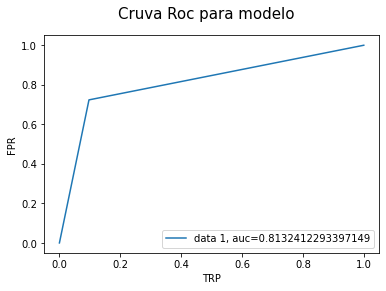

In [109]:
get_metrics_model(X_test, y_test, rf, 0.41)

Si realizamos una comparación del modelo 2 v/s modelo 1, se aprecia:
1. El Data leakage en este caso se debe validad particionando un nuevo conjunto de datos y por una validación cruzada, que nos permitirá impedir que ocurra un overfitting de nuestro modelo manteniendo conjuntos de datos de Train, Test y Validation.
2. Modelo mejora si nos centramos en el AUC, pero no es significante su mejoría el problema es que las observaciones del conjunto de datos de clima vienen dados en por intervalos de un dia completo, mientras que en nuestro conjunto de datos cada observación se realiza en un intervalo de una hora o 12 en este caso.

#### Variables más importantes

<AxesSubplot:title={'center':'Feature importance'}>

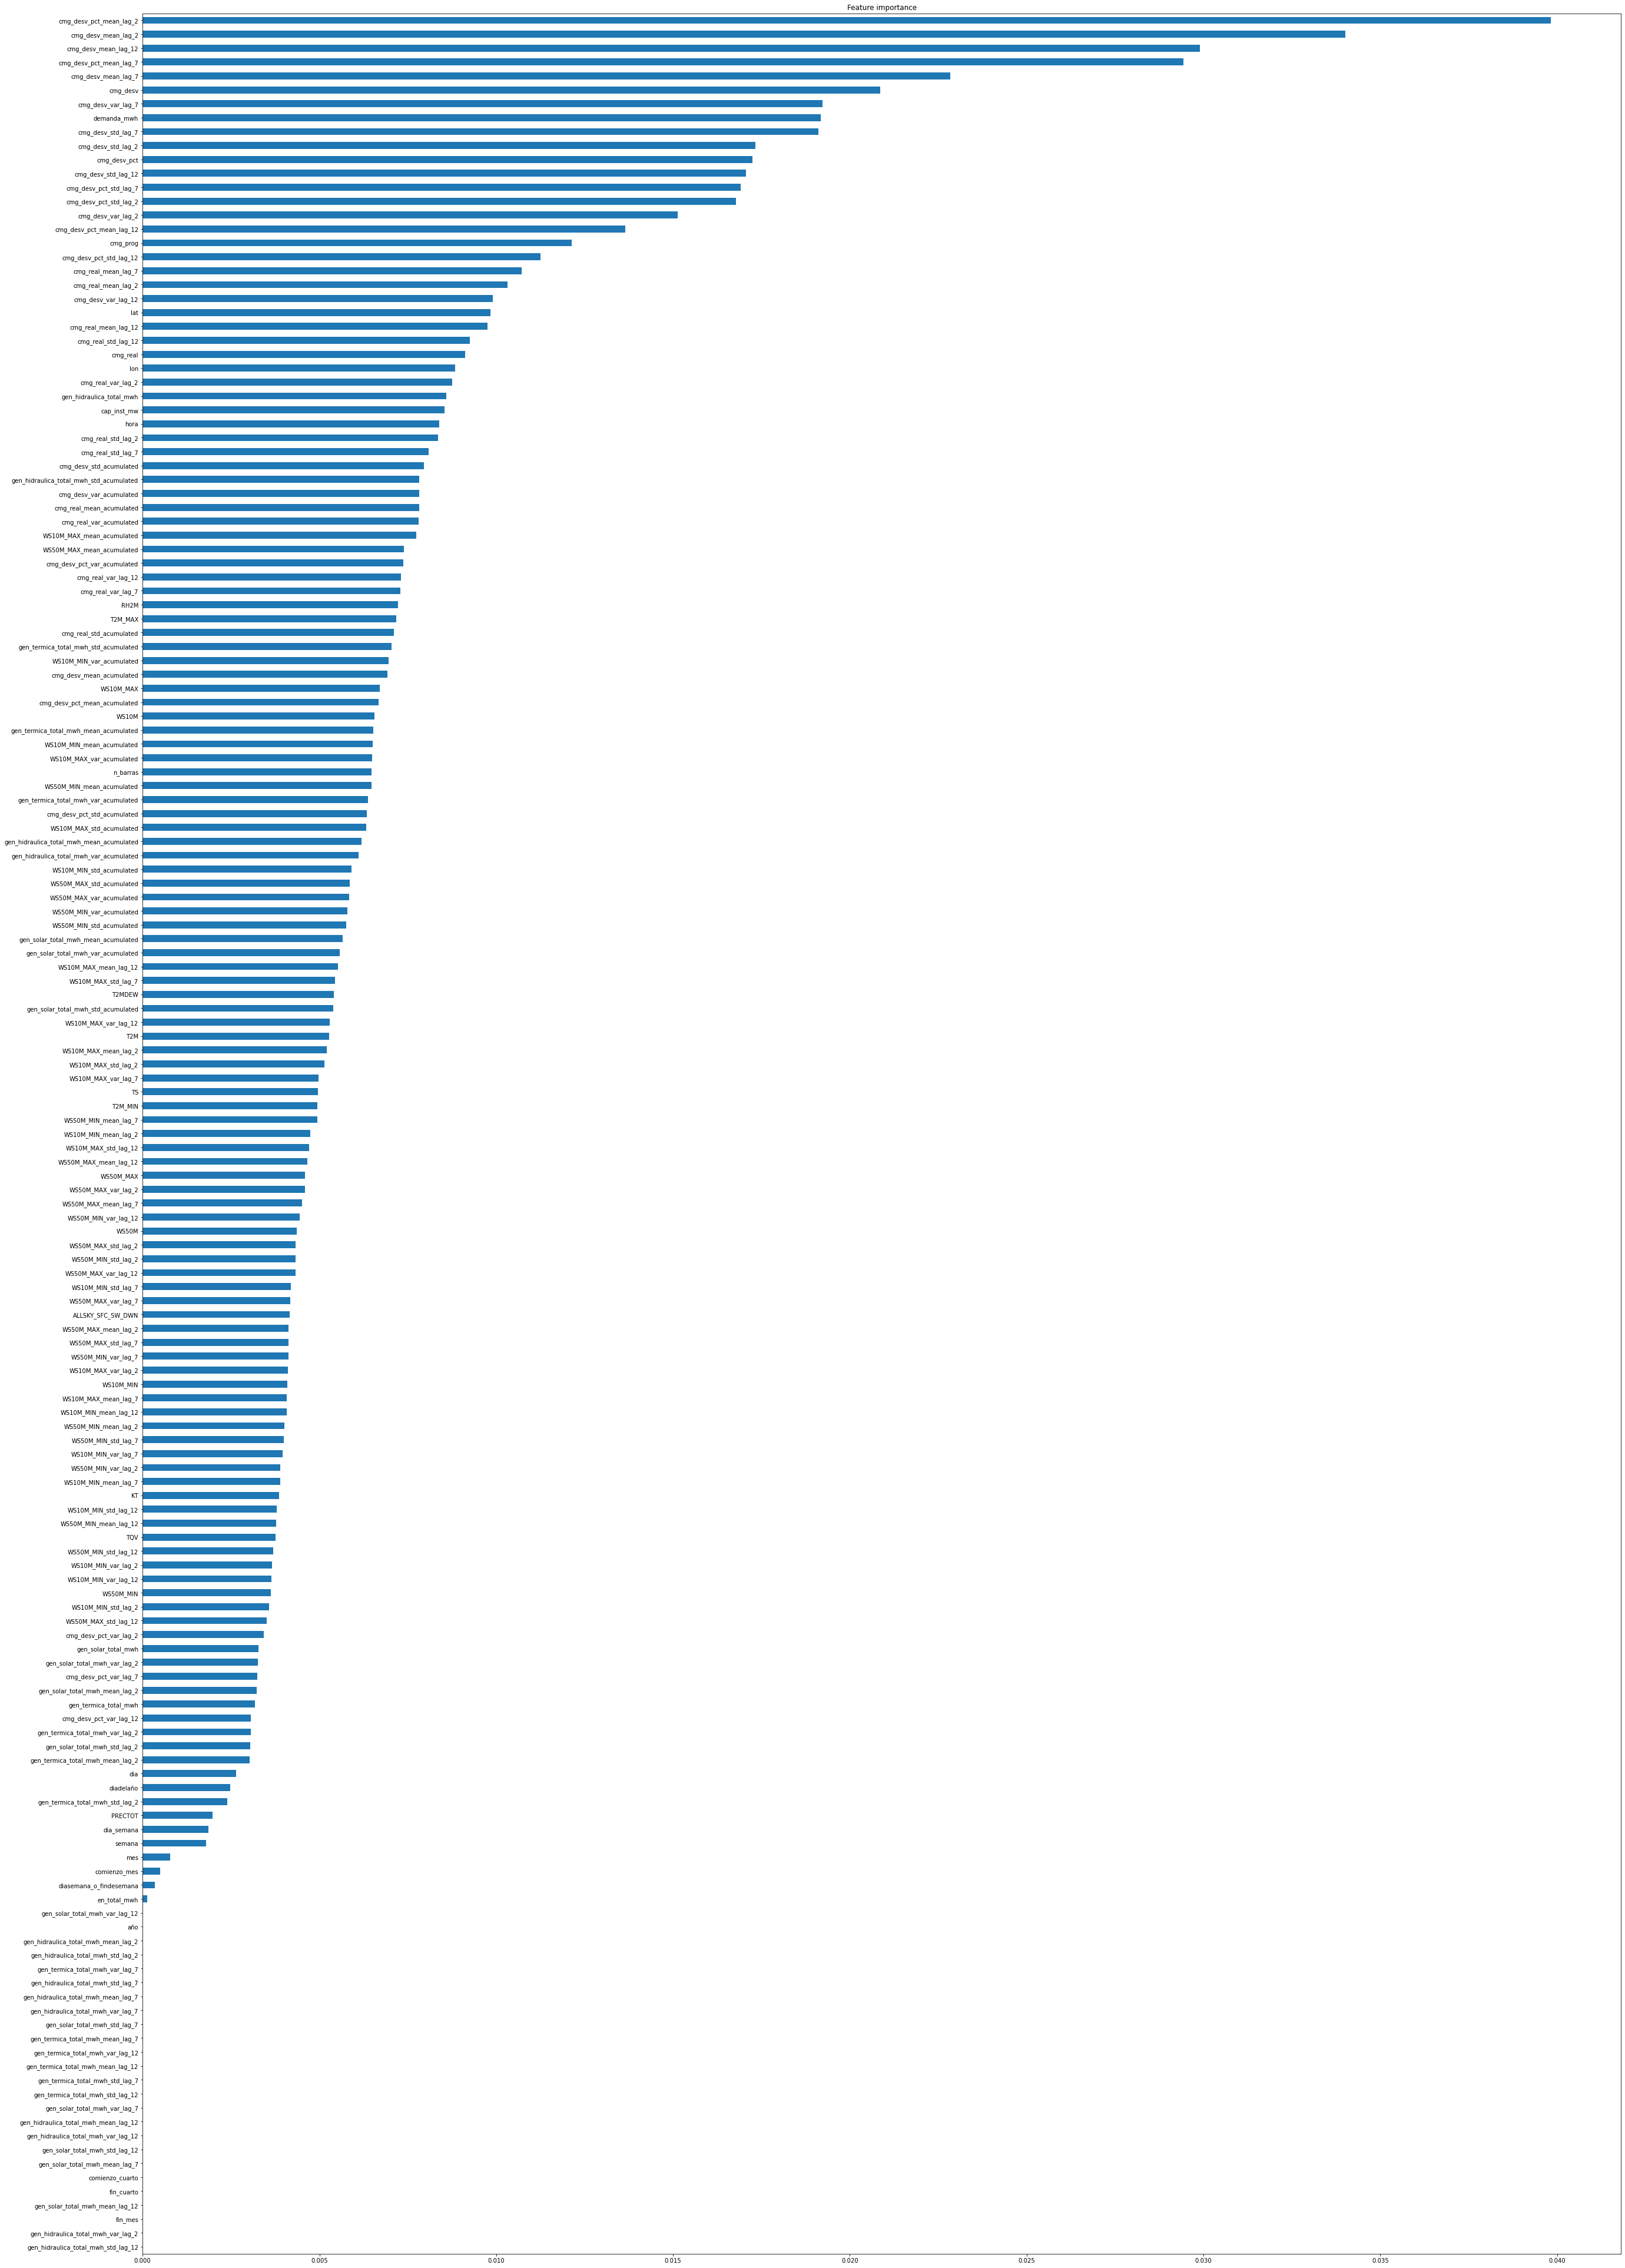

In [106]:
pd.Series(rf.feature_importances_,index=X.columns).sort_values().plot(kind='barh', title='Feature importance', figsize=(45,70))

Las características mas relevantes para el modelo siguen siendo lso que tienen estrecha realación con los costos marginales y sus lags y variables acumuladas, por lo que puede  apreciarse que la manera de integración de los datos del clima no está teniendo el efecto deseado de mejorar la generalización del modelo.

## 8. Reflexión

1. ¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?
R: Debido a la complejidad y embergadura del sistema eléctrico nacional y la importancia para nuestro país, es sumamente importante mantener los costes marginales lo más bajo posibles porque de esta manera se podrían tomar medidas para que los desvios de precios no impacten a las empresas y posiblemente en un futuro a los usuarios.

2. ¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?
R: Un caso porticular podría ser llevado a las personas, de tal manera que por medio de alguna aplicación o servicio se le pronostique cuando podría existir un desvío de precios de la energía y asi anticipar un posible aumento de precio en el consumo, esta idea bien necesitaría poder identificar los desvíos positivos y negativos por lo que habría que modificar el modelo original.
Por otro lado, una alternativa más precisa, puede significar que el Sistema Electrico Nacional, pueda anticiparse a posibles desvíos de energía que pueden repercutir en costos mas altos, pero por otro lado le permitirían indagar en donde o de que forma se genera este desvío de precios por medio de las características mas importantes del modelo.